# MS-CELEB Face Recognition

## Importing the libraries


In [1]:
import os
import shutil
import pathlib
import numpy as np
import keras
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory


# to make this notebook's output stable across runs
np.random.seed(42)

# Constants
SIZE_OF_IMAGES = (256, 256)
# SIZE_OF_IMAGES = (512, 512)
SIZE_OF_BATCH = 8
DATA_DIR = pathlib.Path('./data/14-celebrity-faces-dataset/data/')
MODELS_DIR = pathlib.Path('./models')

print(tf.config.list_physical_devices('GPU'))


2023-01-11 17:21:52.513207: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-01-11 17:21:55.357443: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-11 17:21:55.411555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-01-11 17:21:55.411756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:961] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
from kears_vggface.vggface import VGGFACE

ModuleNotFoundError: No module named 'kears_vggface'

## Functions

In [79]:

def plot_history(history):
    """"Plot the accuracy, loss, precision, recall and AUC \
        curves for training and validation."""

    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    auc = history.history["auc"]
    val_auc = history.history["val_auc"]

    precision = history.history["precision"]
    val_precision = history.history["val_precision"]

    recall = history.history["recall"]
    val_recall = history.history["val_recall"]

    epochs = range(1, len(accuracy) + 1)

    plt.figure(figsize=(12, 12))

    plt.subplot(321)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.grid()

    plt.subplot(322)
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.grid()

    plt.subplot(323)
    plt.plot(epochs, precision, "bo", label="Training precision")
    plt.plot(epochs, val_precision, "b", label="Validation precision")
    plt.title("Training and validation precision")
    plt.legend()
    plt.grid()

    plt.subplot(324)
    plt.plot(epochs, recall, "bo", label="Training recall")
    plt.plot(epochs, val_recall, "b", label="Validation recall")
    plt.title("Training and validation recall")
    plt.legend()
    plt.grid()

    plt.subplot(3, 2, (5, 6))
    plt.plot(epochs, auc, "bo", label="Training AUC")
    plt.plot(epochs, val_auc, "b", label="Validation AUC")
    plt.title("Training and validation AUC")
    plt.legend()
    plt.grid()

    plt.show()


## Importing the data

In [80]:

train_dataset = image_dataset_from_directory(DATA_DIR / "train",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)

validation_dataset = image_dataset_from_directory(DATA_DIR / "val",
                                             image_size=SIZE_OF_IMAGES,
                                             batch_size=SIZE_OF_BATCH,
                                             label_mode='categorical',
                                             color_mode='rgb',
                                             seed=42)


# test_dataset = image_dataset_from_directory(DATAS_DIR / "Testing",
#                                          image_size=SIZE_OF_IMAGES,
#                                          batch_size=SIZE_OF_BATCH,
#                                          label_mode='categorical',
#                                              color_mode='grayscale')

Found 220 files belonging to 14 classes.
Found 70 files belonging to 14 classes.


In [81]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (8, 256, 256, 3)
labels batch shape: (8, 14)


## Implementing Modern DNN Architecture using Residual CNN

In [82]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [83]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(SIZE_OF_IMAGES + (3, )))
x = data_augmentation(inputs)
x = layers.Rescaling(1. / 255)(x)

x = layers.Conv2D(filters=32, kernel_size=5,padding="same", use_bias=False)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation("relu")(x)

def conv_layer_with_batch_norm(filter_size, kernel_size=3):
    global x
    x = layers.SeparableConv2D(filters=filter_size,
                      kernel_size=kernel_size,
                      use_bias=False,
                      padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    return x



x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

x = conv_layer_with_batch_norm(32, kernel_size=5)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)


x = conv_layer_with_batch_norm(64, kernel_size=3)
x = conv_layer_with_batch_norm(64, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)

residual = x
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = conv_layer_with_batch_norm(128, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(128, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(256, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(256, 1, strides=(2, 2), use_bias=False)(residual)
x = layers.Add()([residual, x])

residual = x
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = conv_layer_with_batch_norm(512, kernel_size=3)
x = layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(x)
residual = layers.Conv2D(512, 1, strides=(2, 2), use_bias=False)(residual)
residual = layers.BatchNormalization()(residual)
x = layers.Add()([residual, x])

x = conv_layer_with_batch_norm(1024, kernel_size=3)

x = layers.GlobalAveragePooling2D()(x)

x = layers.Dropout(0.5)(x)
outputs = layers.Dense(14, activation='softmax')(x)

model = keras.Model(inputs=inputs,
                    outputs=outputs,
                    name='Modern_Architecture_ERS')


In [84]:
model.summary()

Model: "Modern_Architecture_ERS"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential_7 (Sequential)      (None, 256, 256, 3)  0           ['input_12[0][0]']               
                                                                                                  
 rescaling_11 (Rescaling)       (None, 256, 256, 3)  0           ['sequential_7[0][0]']           
                                                                                                  
 conv2d_96 (Conv2D)             (None, 256, 256, 32  2400        ['rescaling

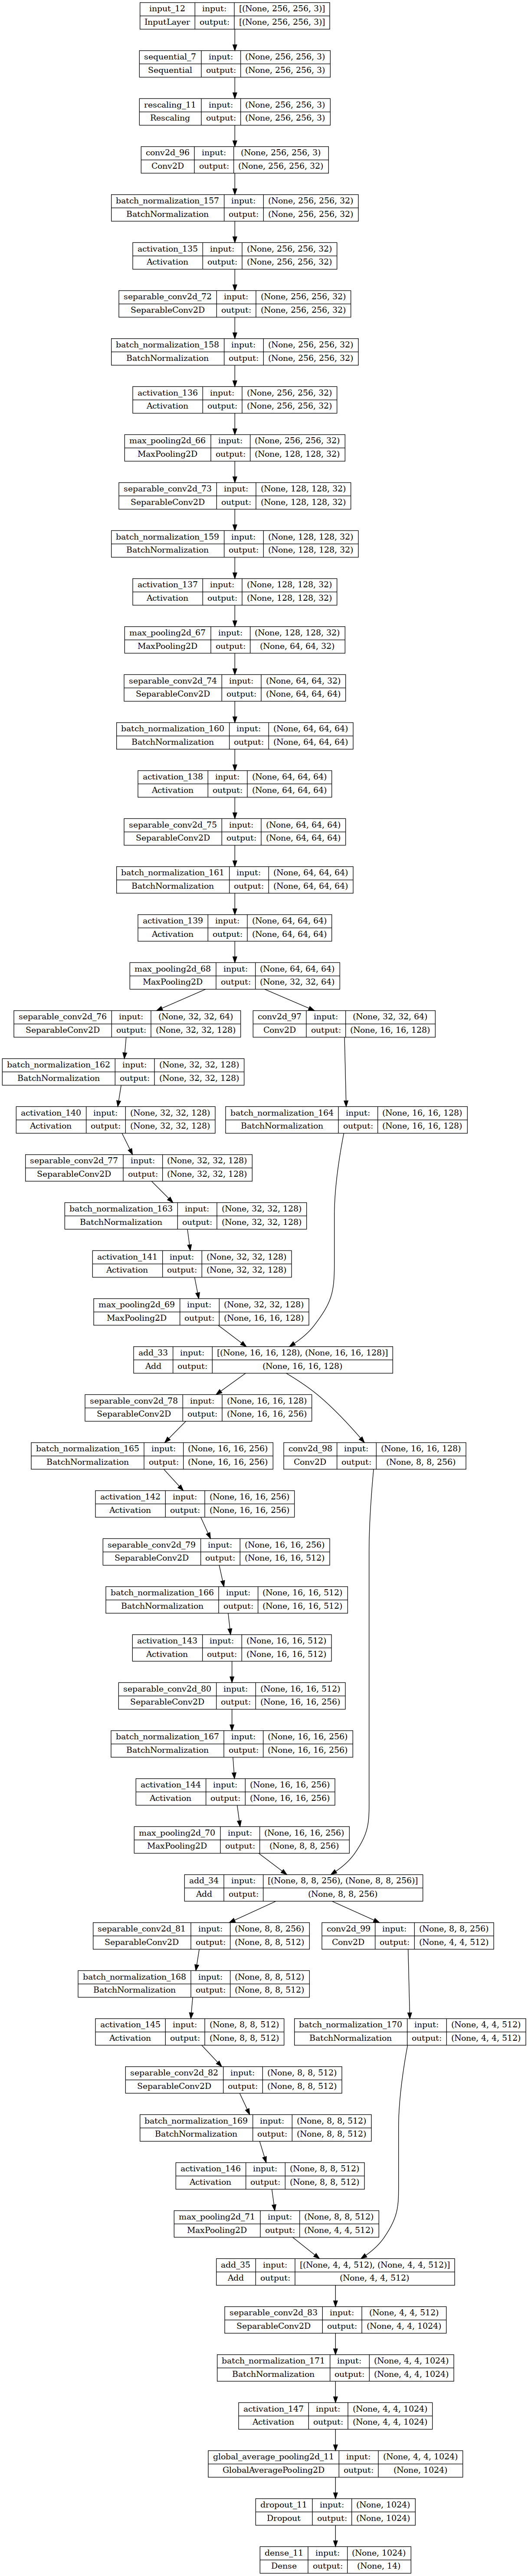

In [85]:
keras.utils.plot_model(model,
                       show_shapes=True,
                       show_layer_names=True,
                       to_file='./pngs/model.png')


In [86]:
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=os.path.join(
        MODELS_DIR, 'modern_arch_ERS.keras'),
                                    save_best_only=True,
                                    monitor="val_loss")
]
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=validation_dataset,
                    callbacks=callbacks)


Epoch 1/50
28/28 [==============================] - 9s 172ms/step - loss: 3.0566 - accuracy: 0.0682 - auc: 0.5337 - precision: 0.0556 - recall: 0.0045 - val_loss: 2.6380 - val_accuracy: 0.0714 - val_auc: 0.5154 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/50
28/28 [==============================] - 4s 126ms/step - loss: 2.7280 - accuracy: 0.1318 - auc: 0.6231 - precision: 0.1429 - recall: 0.0091 - val_loss: 2.6371 - val_accuracy: 0.0857 - val_auc: 0.5137 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/50
28/28 [==============================] - 3s 124ms/step - loss: 2.6367 - accuracy: 0.1545 - auc: 0.6546 - precision: 0.2000 - recall: 0.0136 - val_loss: 2.6371 - val_accuracy: 0.0857 - val_auc: 0.5170 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/50
28/28 [==============================] - 3s 122ms/step - loss: 2.6082 - accuracy: 0.2045 - auc: 0.6575 - precision: 0.3333 - recall: 0.0273 - val_loss: 2.6378 - val_accuracy: 0.0857 - val_auc: 0.51

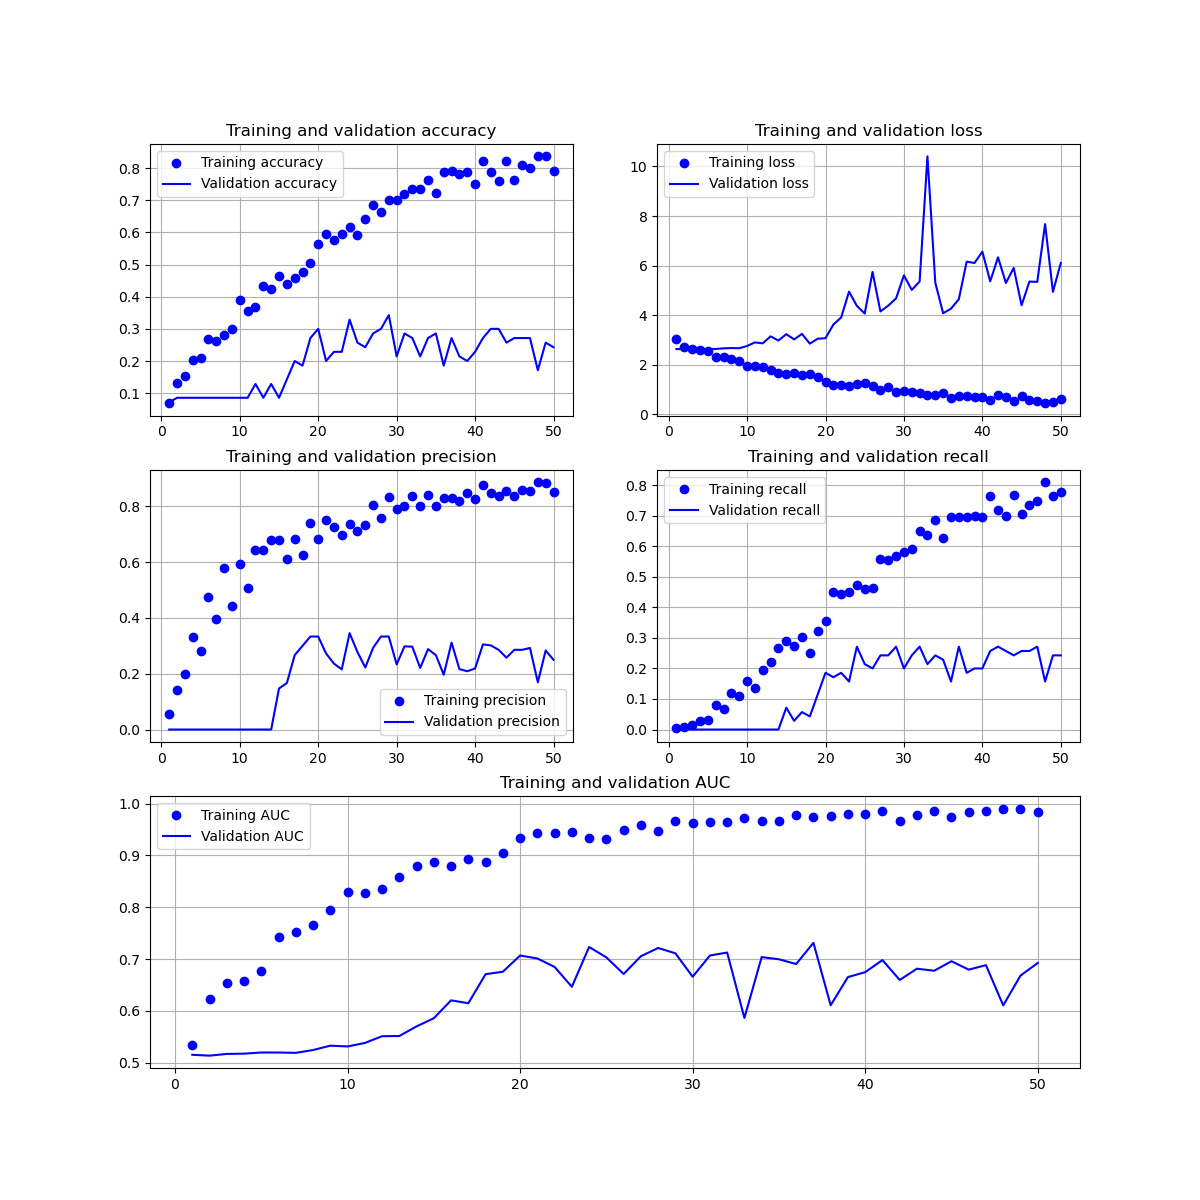

In [87]:
plot_history(history)


In [88]:

# test_model = keras.models.load_model(
#     os.path.join(MODELS_DIR, 'modern_arch_ERS.keras'))
# show_eval_results(test_model, test_dataset)